In [ ]:
!pip install yfinance

In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [3]:
# On average there are 252 trading days in a year
NUM_TRADING_DAYS = 252

NUM_PORTFOLIOS = 10000

# Stocks to be included in the portfolio
stocks = ['FB','AAPL','AMZN','NFLX','GOOG']

start_date = '2011-01-01'
end_date = '2022-01-01'

def download_data():
  stock_data = {}
  for stock in stocks:
    ticker = yf.Ticker(stock)
    stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
  return pd.DataFrame(stock_data)

def show_data(data):
  data.plot(figsize=(10,5))
  plt.title("Comparative Stock Price Chart")
  plt.show()

In [4]:
def calculate_return(data):
  # Normalization - we want to measure all variables in comparable metric. So we use Logarithmic returns
  log_return = np.log(data/data.shift(1))     #Daily Logarithmic return
  return log_return[1:]   #Removing the first row of returns as it has NaN values

def show_statistics(returns):
  # Instead of daily, we're after annual metrics (mean and covariance)
  print(returns.mean() * NUM_TRADING_DAYS)    #mean of annual returns
  print(returns.cov() * NUM_TRADING_DAYS)  #Covariance of annual return


def show_mean_variance(returns, weights):
  # Annual Returns
  portfolio_return = np.sum(returns.mean()*weights) * NUM_TRADING_DAYS
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
  print("Expected Portfolio return (mean): ", portfolio_return)
  print("Expected Portfolio volatility (standard deviation): ", portfolio_volatility)

#--------------------Generating Portfolios---------------------
def generate_portfolios(returns):
  #we'll generate random weights w to generate different portfolios
  portfolio_means=[]   #list to store means(returns)
  portfolio_risks=[]   #list to store risks(volatility)
  portfolio_weights=[]

  for _ in range(NUM_PORTFOLIOS): 
    w = np.random.random(len(stocks)) #creating random 1D array for weights with len = no. of stocks
    w /= np.sum(w)   #normalising weights so that their sum is equal to 1
    portfolio_weights.append(w)
    portfolio_means.append(np.sum(returns.mean()* w) * NUM_TRADING_DAYS)
    portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

  return np.array(portfolio_weights) , np.array(portfolio_means) , np.array(portfolio_risks)

def show_portfolios(returns, volatilities):
  plt.figure(figsize=(10,6))
  plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
  plt.grid(True)
  plt.xlabel('Expected Volatility')
  plt.ylabel('Expected Return')
  plt.colorbar(label='Sharpe Ratio')
  plt.title('Return vs Risk Plot')
  plt.show()

def statistics(weights, returns):
  portfolio_return = np.sum(returns.mean()*weights) * NUM_TRADING_DAYS
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
  return np.array([portfolio_return, portfolio_volatility, portfolio_return/portfolio_volatility])

#-----------------Optimizing the Portfolios-------------------- 

#scipy optimize module can find minimum of a given function
#We need to find portfolio with max sharpe ratio.
#Max of a f(x) is min of -f(x)
def min_function_sharpe(weights, returns):
  return -statistics(weights, returns)[2]

#Constraints: Sum of weights = 1
#Scipy optimize can optimize a function like: f(x)=0
#So, for our case f(x) = sum of weights (x) -1 = 0
def optimize_portfolio(weights, returns):
  #Sum of weights =1
  constraints = {'type' : 'eq', 'fun' : lambda x: np.sum(x)-1}
  #Weights can be in the range [0,1]
  bounds = tuple((0,1) for _ in range(len(stocks)))  #for each stock a tuple (0,1) will be created
  return optimization.minimize(fun=min_function_sharpe, x0 = weights[0], args = returns, method='SLSQP', bounds=bounds, constraints=constraints)

# To print the optimal portfolio weights, returns, risk and sharpe ratio
def print_optimal_portfolio(optimum, returns):
  print("Optimal Portflio: ", optimum['x'].round(3))   #printing the optimal weights
  print("Expected return, volatility and Sharpe Ratio: ", statistics(optimum['x'].round(3), returns)) 

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
  plt.figure(figsize=(10,6))
  plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets/portfolio_vols, marker='o')
  plt.grid(True)
  plt.xlabel('Expected Volatility')
  plt.ylabel('Expected Return')
  plt.colorbar(label='Sharpe Ratio')
  plt.title('Return vs Risk Plot with Optimal Portflio')
  plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*' , markersize=20)
  plt.show()

                    FB        AAPL         AMZN        NFLX         GOOG
Date                                                                    
2011-01-03         NaN   10.063868   184.220001   25.487143   301.046600
2011-01-04         NaN   10.116389   185.009995   25.910000   299.935760
2011-01-05         NaN   10.199140   187.419998   25.675714   303.397797
2011-01-06         NaN   10.190897   185.860001   25.427143   305.604523
2011-01-07         NaN   10.263881   185.490005   25.614286   307.069031
...                ...         ...          ...         ...          ...
2021-12-27  346.179993  179.836319  3393.389893  613.119995  2961.280029
2021-12-28  346.220001  178.799164  3413.219971  610.710022  2928.959961
2021-12-29  342.940002  178.888916  3384.020020  610.539978  2930.090088
2021-12-30  344.359985  177.712143  3372.889893  612.090027  2920.050049
2021-12-31  336.350006  177.083878  3334.340088  602.440002  2893.590088

[2769 rows x 5 columns]


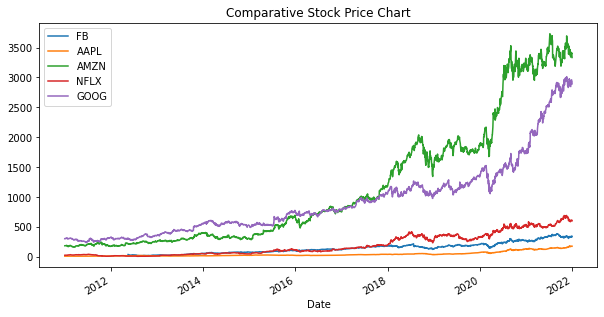

FB      0.226345
AAPL    0.261074
AMZN    0.263644
NFLX    0.287944
GOOG    0.206023
dtype: float64
            FB      AAPL      AMZN      NFLX      GOOG
FB    0.132622  0.041912  0.049890  0.050435  0.046551
AAPL  0.041912  0.079496  0.039386  0.037714  0.037981
AMZN  0.049890  0.039386  0.095675  0.063329  0.045464
NFLX  0.050435  0.037714  0.063329  0.244365  0.045332
GOOG  0.046551  0.037981  0.045464  0.045332  0.065190


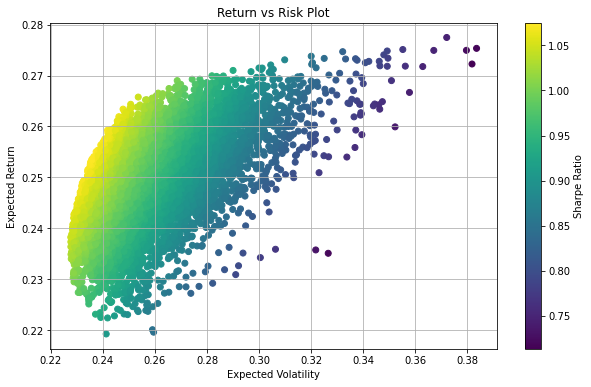

Optimal Portflio:  [0.046 0.451 0.267 0.081 0.154]
Expected return, volatility and Sharpe Ratio:  [0.25360038 0.23568098 1.07603243]


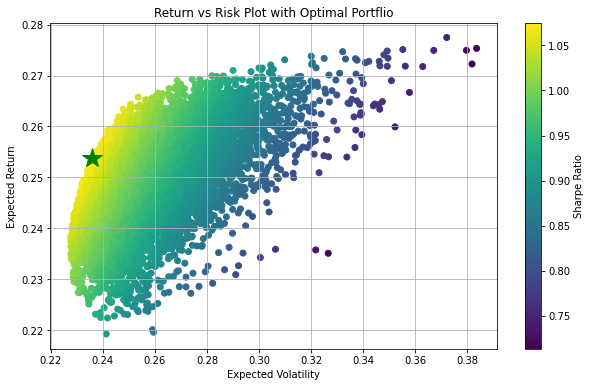

In [5]:
if __name__ == '__main__':
  dataset = download_data()
  # Printing the stock price Dataframe of last 1 decade 
  print(dataset)
  # Plotting the comparative stock price chart for the 6 companies
  show_data(dataset)

  log_daily_returns = calculate_return(dataset)
  #Printing the annual means and the covariance matrix  
  show_statistics(log_daily_returns)

  #Generating 10k portfolios
  pweights, means, risks = generate_portfolios(log_daily_returns)
  #Plotting the return vs risk plot for the 10k portfolios
  show_portfolios(means, risks)

  #Getting the optimal portfolio
  optimum = optimize_portfolio(pweights, log_daily_returns)
  #Printing the optimal portfolio 
  print_optimal_portfolio(optimum, log_daily_returns)
  #Plotting the optimal portfolio (with gree star) in the return vs risk plot
  show_optimal_portfolio(optimum, log_daily_returns, means, risks)

*(Note: Not meant as a financial advice)*

The above results suggest that according to the data of last one decade, an optimal portfolio diversification among the FAANG companies would be something like: 5.9% in FB, 46% in AAPL, 38% in AMZN, 9.2% in NFLX and 0% in GOOG. At this distribution, you can achieve 27% annual returns at 25% risk with best return-to-risk ratio being 1.08.